# Mie Scattering Algorithms

**Scott Prahl**

**April 2021**

This Jupyter notebook shows the formulas used in `miepython`.  This code is heavily influenced by Wiscomes MIEV0 code as documented in his [paper on Mie scattering](https://www.researchgate.net/publication/41895770_Improved_Mie_Scattering_Algorithms) and his [1979 NCAR](https://www.researchgate.net/publication/253485579_Mie_Scattering_Calculations_Advances_in_Technique_and_Fast_Vector-speed_Computer_Codes) and [1996 NCAR](http://dust.ess.uci.edu/ppr/ppr_Wis79.pdf) publications.

There are a couple of things that set this code apart from other python Mie codes.  

1) Instead of using the built-in special functions from SciPy, the calculation relies on the logarthmic derivative of the Ricatti-Bessel functions.  This technique is significantly more accurate.

2) The code uses special cases for small spheres.  This is faster and more accurate

3) The code works when the index of refraction `m.real` is zero or when `m.imag` is very large (negative).

The code has been tested up to sizes ($x=2\pi r/\lambda=10000$).

*If miepython is not installed, uncomment the following cell (i.e., delete the #) and run (shift-enter)*

In [1]:
#!pip install --user miepython

In [2]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import miepython.miepython_jit as miepython

except ModuleNotFoundError:
    print('miepython not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')

## The logarithmic derivative $D_n$.

This routine uses a continued fraction method to compute $D_n(z)$
proposed by Lentz. *Lentz uses the notation $A_n$ 
instead of $D_n$, but I prefer the notation used by Bohren and Huffman.*
This method eliminates many weaknesses in previous algorithms using
forward recursion. 

The logarithmic derivative $D_n$ is defined as

$$
D_n = -\frac{n}{z} + \frac{J_{n-1/2}(z)}{J_{n+1/2}(z)} 
$$

Equation (5) in Lentz's paper can be used to obtain

$$
\frac{J_{n-1/2}(z)}{J_{n+1/2}(z)} =
{2n+1 \over z} + {1\over\displaystyle -\frac{2n+3}{z} +
                  {\strut 1 \over\displaystyle \frac{2n+5}{z} +
                      {\strut 1 \over\displaystyle -\frac{2n+7}{z} + \cdots}}}
$$

Now if

$$
\alpha_{i,j}=[a_i,a_{i-1},\ldots,a_j] = a_i + \frac{1}{\displaystyle a_{i-1} +
                  \frac{\strut 1}{\displaystyle a_{i-2} + \cdots
                      \frac{\strut 1 }{\displaystyle a_j}}}
$$

we seek to create 

$$
\alpha = \alpha_{1,1}\,\alpha_{2,1}\cdots \alpha_{j,1} 
\qquad
\beta = \alpha_{2,2}\,\alpha_{3,2}\cdots \alpha_{j,2} 
$$

since Lentz showed that

$$
\frac{J_{n-1/2}(z)}{J_{n+1/2}(z)} \approx \frac{\alpha}{\beta}
$$

The whole goal is to iterate until the $\alpha$ and $\beta$
are identical to the number of digits desired. Once this is
achieved, then use equations this equation and the first equation for
the logarithmic derivative to calculate
$D_n(z)$.

### First terms

The value of $a_j$ is

$$
a_j = (-1)^{j+1} {2n+2j-1\over z}
$$

The first terms for $\alpha$ and $\beta$ are then

$$
\alpha = a_1 \left(a_2 + \frac{1}{a_1}\right)
\qquad
\beta = a_2
$$

### Later terms

To calculate the next $\alpha$ and $\beta$, I use

$$
a_{j+1} =  -a_j+(-1)^j\,{2\over z}
$$

to find the next $a_j$ and

$$
\alpha_{j+1} = a_j + \frac{1}{\alpha_j},
\qquad\hbox{and}\qquad
\beta_{j+1} = a_j + \frac{1}{\beta_j}
$$

### Calculating $D_n$

Use formula 7 from Wiscombe's paper to figure out if upwards or downwards recurrence should be used.  Namely if

$$
m_{\rm Im}x\le 13.78 m_{\rm Re}^2 - 10.8 m_{\rm Re} + 3.9
$$

the upward recurrence would be stable.

The returned array `D` is set-up so that $D_n(z)=$ `D[n]`.  Therefore the first value for $D_1(z)$ will not be `D[0]`, but rather  `D[1]`.

### $D_n$ by downwards recurrence.

Start downwards recurrence using by accurately calculating `D[nstop]` using the Lentz method, then find earlier
terms of the logarithmic derivative $D_n(z)$ using the recurrence relation,

$$
D_{n-1}(z) = \frac{n}{z} - \frac{1}{D_n(z) + n/z}
$$

This is a pretty straightforward procedure.
  

### $D_n$ by upward recurrence.

Calculating the logarithmic derivative $D_n(\rho)$ using the upward recurrence relation,

$$
D_n(z) = \frac{1}{n/z - D_{n-1}(z)}-\frac{n}{z}
$$

To calculate the initial value `D[1]` we use Wiscombe's representation that avoids overflow errors when the usual $D_0(x)=1/tan(z)$ is used.

$$
D_1(z) = -\frac{1}{z}+\frac{1-\exp(-2jz)}{[1-\exp(-2jz)]/z - j[1+\exp(-2jz)]}
$$

In [3]:
m = 1
x = 1
nstop = 10

dn = np.zeros(nstop, dtype=np.complex128)

print("both techniques work up to 5")
n=5
print("    Lentz",n,miepython._Lentz_Dn(m*x,n).real)
miepython._D_downwards(m*x,nstop, dn)
print("downwards",n, dn[n].real)
miepython._D_upwards(m*x,nstop, dn)
print("  upwards",n, dn[n].real)

print("but upwards fails badly by n=9")
n=9
print("    Lentz",n,miepython._Lentz_Dn(m*x,n).real)
miepython._D_downwards(m*x, nstop, dn)
print("downwards",n,dn[n].real)
miepython._D_upwards(m*x, nstop, dn)
print("  upwards",n,dn[n].real)

both techniques work up to 5
    Lentz 5 5.922678838321971
downwards 5 5.922678838321968
  upwards 5 5.922678842006903
but upwards fails badly by n=9
    Lentz 9 9.952281984945753
downwards 9 9.952281984945756
  upwards 9 67.02345742657965


## Calculating $A_n$ and $B_n$

OK,  Here we go.  We need to start up the arrays.  First, recall
(page 128 Bohren and Huffman) that

$$
\psi_n(x) = x j_n(x)\qquad\hbox{and}\qquad \xi_n(x) = x j_n(x) + i x y_n(x)
$$

where $j_n$ and $y_n$ are spherical Bessel functions.  The first few terms
may be worked out as,

$$
\psi_0(x) = \sin x 
\qquad\hbox{and}\qquad
\psi_1(x) = \frac{\sin x}{x} - \cos x
$$

and

$$
\xi_0(x) = \psi_0 + i \cos x
\qquad\hbox{and}\qquad
\xi_1(x) = \psi_1 + i \left[\frac{\cos x}{x} + \sin x\right]
$$

The main equations for $a_n$ and $b_n$ in Bohren and Huffman Equation (4.88).

$$
a_n = \frac{\Big[ D_n(mx)/m + n/x\Big] \psi_n(x)-\psi_{n-1}(x)}
           {\Big[ D_n(mx)/m + n/x\Big] \xi_n(x)- \xi_{n-1}(x)}
$$

and

$$
b_n = \frac{\Big[m D_n(mx) + n/x\Big] \psi_n(x)-\psi_{n-1}(x)}
           {\Big[m D_n(mx) + n/x\Big] \xi_n(x)- \xi_{n-1}(x)}
$$

The recurrence relations for $\psi$ and $\xi$ depend on the recursion relations
for the spherical Bessel functions (page 96 equation 4.11)

$$
z_{n-1}(x) + z_{n+1}(x) = {2n+1\over x} z_n(x)
$$

where $z_n$ might be either $j_n$ or $y_n$.   Thus

$$
\psi_{n+1}(x) = {2n+1\over x} \psi_n(x) - \psi_{n-1}(x)
\qquad\hbox{and}\qquad
\xi_{n+1}(x) = {2n+1\over x} \xi_n(x) - \xi_{n-1}(x)
$$

If the spheres are perfectly reflecting `m.real=0` then Kerker gives
equations for $a_n$ and $b_n$ that do not depend on $D_n$ at all

$$
a_n = \frac{n\psi_n(x)/x-\psi_{n-1}(x)}
           {n\xi_n(x)/x- \xi_{n-1}(x)}
$$

and

$$
b_n = \frac{\psi_n(x)}{\xi_n(x)}
$$

Therefore `D[n]` will directly correspond to $D_n$ in Bohren.  However, `a` and `b` will be zero based arrays and so $a_1$=`a[0]` or $b_n$=`b[n-1]`


In [4]:
m=4/3
x=50
print("m=4/3 test, m=",m, " x=",x)
nstop = int(x + 4.05 * x**0.33333 + 2.0) + 1
a = np.zeros(nstop - 1, dtype=np.complex128)
b = np.zeros(nstop - 1, dtype=np.complex128)
miepython._mie_An_Bn(m,x,a,b)
print("a_1=", a[0])
print("a_1= (0.531105889295-0.499031485631j)  #test")
print("b_1=", b[0])
print("b_1= (0.791924475935-0.405931152229j)  #test")
print()

m=3/2-1j
x=2
print("upward recurrence test, m=",m, " x=",x)
nstop = int(x + 4.05 * x**0.33333 + 2.0) + 1
a = np.zeros(nstop - 1, dtype=np.complex128)
b = np.zeros(nstop - 1, dtype=np.complex128)
miepython._mie_An_Bn(m,x,a,b)

print("a_1=", a[0])
print("a_1= (0.546520203397-0.152373857258j)  #test")
print("b_1=", b[0])
print("b_1= (0.389714727888+0.227896075256j)  #test")
print()

m=11/10-25j
x=2
print("downward recurrence test, m=",m, " x=",x)
nstop = int(x + 4.05 * x**0.33333 + 2.0) + 1
a = np.zeros(nstop - 1, dtype=np.complex128)
b = np.zeros(nstop - 1, dtype=np.complex128)
miepython._mie_An_Bn(m,x,a,b)

print("a_1=", a[0])
print("a_1= (0.322406907480-0.465063542971j)  #test")
print("b_1=", b[0])
print("b_1= (0.575167279092+0.492912495262j)  #test")

m=4/3 test, m= 1.3333333333333333  x= 50
a_1= (0.5311058892948326+0.4990314856310949j)
a_1= (0.531105889295-0.499031485631j)  #test
b_1= (0.7919244759351927+0.40593115222899945j)
b_1= (0.791924475935-0.405931152229j)  #test

upward recurrence test, m= (1.5-1j)  x= 2
a_1= (0.5465202033970914+0.1523738572575972j)
a_1= (0.546520203397-0.152373857258j)  #test
b_1= (0.3897147278879423-0.22789607525649083j)
b_1= (0.389714727888+0.227896075256j)  #test

downward recurrence test, m= (1.1-25j)  x= 2
a_1= (0.322406907480758+0.46506354297157615j)
a_1= (0.322406907480-0.465063542971j)  #test
b_1= (0.5751672790921923-0.4929124952616479j)
b_1= (0.575167279092+0.492912495262j)  #test


## Small Spheres

This calculates everything accurately for small spheres.  This approximation
is necessary because in the small particle or Rayleigh limit $x\rightarrow0$ the
Mie formulas become ill-conditioned.  The method was taken from Wiscombe's paper
and has been tested for several complex indices of refraction.       
Wiscombe uses this when 

$$
x\vert m\vert\le0.1
$$ 

and says this routine should be accurate to six places.  

The formula for ${\hat a}_1$ is

$$
{\hat a}_1 = 2i\frac{m^2-1}{3}\frac{1-0.1x^2+\frac{\displaystyle4m^2+5}{\displaystyle1400}x^4}{D}
$$

where

$$
D=m^2+2+(1-0.7m^2)x^2-\frac{8m^4-385m^2+350}{1400}x^4+2i\frac{m^2-1}{3}x^3(1-0.1x^2)
$$

Note that I have disabled the case when the sphere has no index of refraction.
The perfectly conducting sphere equations are 


The formula for ${\hat b}_1$ is

$$
{\hat b}_1 = ix^2\frac{m^2-1}{45}  \frac{1+\frac{\displaystyle2m^2-5}{\displaystyle70}x^2}{1-\frac{\displaystyle2m^2-5}{\displaystyle30}x^2}
$$


The formula for ${\hat a}_2$ is

$$
{\hat a}_2 = ix^2 \frac{m^2-1}{15} \frac{1-\frac{\displaystyle1}{\displaystyle14}x^2}{2m^2+3-\frac{\displaystyle2m^2-7}{\displaystyle14}x^2}
$$


The scattering and extinction efficiencies are given by

$$
Q_\mathrm{ext} = 6x \cdot \mathcal{Re}\left[{\hat a}_1+{\hat b}_1+\frac{5}{3}{\hat a}_2\right]
$$

and
$$
Q_\mathrm{sca} = 6x^4 T 
$$

with

$$
T         =\vert{\hat a}_1\vert^2+\vert{\hat b}_1\vert^2+\frac{5}{3}\vert{\hat a}_2\vert^2
$$

and the anisotropy (average cosine of the phase function) is

$$
g          =\frac{1}{T}\cdot {\cal Re}\left[{\hat a}_1({\hat a}_2+{\hat b}_1)^*\right] 
$$

The backscattering efficiency $Q_\mathrm{back}$ is 

$$
Q_\mathrm{back} = \frac{\vert S_1(-1)\vert^2 }{ x^2}
$$

where $S_1(\mu)$ is

$$
\frac{S_1(-1)}{x}=\frac{3}{2}x^2\left[{\hat a}_1-{\hat b}_1-\frac{5}{3}{\hat a}_2\right] 
$$


In [5]:
m=1.5-0.1j
x=0.0665
print("abs(m*x)=",abs(m*x))
qext, qsca, qback, g = miepython._small_mie(m,x)
print("Qext=",qext)
print("Qsca=",qsca)
print("Qabs=",qext-qsca)
print("Qback=",qback)
print("g=",g)

print()
print('The following should be nearly the same as those above:')
print()

x=0.067
print("abs(m*x)=",abs(m*x))
qext, qsca, qback, g = miepython.mie(m,x)
print("Qext=",qext)
print("Qsca=",qsca)
print("Qabs=",qext-qsca)
print("Qback=",qback)
print("g=",g)

abs(m*x)= 0.09997142091617985
Qext= 0.013287673090500258
Qsca= 4.699313232220918e-06
Qabs= 0.013282973777268036
Qback= 7.034282738345809e-06
g= 0.0008751930053081949

The following should be nearly the same as those above:

abs(m*x)= 0.1007230857350985
Qext= 0.01338818616894945
Qsca= 4.842269259059637e-06
Qabs= 0.01338334389969039
Qback= 7.248043663523824e-06
g= 0.0008883994938537194


## Small Perfectly Reflecting Spheres

The above equations fail when `m.real=0` so use these approximations when the sphere is small and refective

In [6]:
m = 0 - 0.01j
x=0.099
qext, qsca, qback, g = miepython._small_conducting_mie(m,x)
print("Qext =",qext)
print("Qsca =",qsca)
print("Qabs =",qext-qsca)
print("Qback=",qback)
print("g    =",g)


print()
print('The following should be nearly the same as those above:')
print()

m = 0 - 0.01j
x=0.1001
qext, qsca, qback2, g = miepython.mie(m,x)
print("Qext =",qext)
print("Qsca =",qsca)
print("Qabs =",qext-qsca)
print("Qback=",qback2)
print("g    =",g)

Qext = 0.0003209674075568899
Qsca = 0.0003209674075568899
Qabs = 0.0
Qback= 0.0008630007227881902
g    = -0.3973569106511184

The following should be nearly the same as those above:

Qext = 0.0003354723827494582
Qsca = 0.0003354723827494582
Qabs = 0.0
Qback= 0.0009019313744165619
g    = -0.3973104927402611


## Mie scattering calculations

From page 120 of Bohren and Huffman the anisotropy is given by

$$
Q_{\rm sca}\langle \cos\theta\rangle = \frac{4}{x^2} \left[
\sum_{n=1}^{\infty} \frac{n(n+2)}{n+1} \mbox{Re}\lbrace a_na_{n+1}^*+b_nb_{n+1}^*\rbrace
+ \sum_{n=1}^{\infty} \frac{2n+1}{n(n+1)} \mbox{Re}\lbrace a_nb_n^*\rbrace\right]
$$

For computation purposes, this must be rewritten as

$$
Q_{\rm sca}\langle \cos\theta\rangle = \frac{4}{x^2} \left[
\sum_{n=2}^{\infty} \frac{(n^2-1)}{n} \mbox{Re}\lbrace a_{n-1}a_n^*+b_{n-1}b_n^*\rbrace
+ \sum_{n=1}^{\infty} \frac{2n+1}{n(n+1)} \mbox{Re}\lbrace a_nb_n^*\rbrace\right]
$$

From page 122 we find an expression for the backscattering efficiency

$$
Q_{\rm back} = \frac{\sigma_b}{\pi a^2} = \frac{1}{x^2} \left\vert
\sum_{n=1}^{\infty} (2n+1)(-1)^n(a_n-b_n)\right\vert^2
$$

From page 103 we find an expression for the scattering cross section

$$
Q_{\rm sca} = \frac{\sigma_s}{\pi a^2}
= \frac{2}{x^2}\sum_{n=1}^{\infty} (2n+1)(\vert a_n\vert^2+\vert b_n\vert^2)
$$

The total extinction efficiency is also found on page 103
$$
Q_{\rm ext}= \frac{\sigma_t}{\pi a^2}
= \frac{2}{x^2}\sum_{n=1}^{\infty} (2n+1)\cdot\mbox{Re}\{a_n+b_n\}
$$

In [7]:
qext, qsca, qback, g = miepython.mie(1.55-0.0j,2*np.pi/0.6328*0.525)
print("Qext=",qext)
print("Qsca=",qsca)
print("Qabs=",qext-qsca)
print("Qback=",qback)
print("g=",g)

Qext= 3.1054255314658765
Qsca= 3.1054255314658765
Qabs= 0.0
Qback= 2.925340651067422
g= 0.6331367580408949


In [8]:
x=1000.0
m=1.5-0.1j
qext, qsca, qback, g = miepython.mie(m,x)
print("Qext=",qext)
print("Qsca=",qsca)
print("Qabs=",qext-qsca)
print("Qback=",qback)
print("g=",g)

Qext= 2.0197025206275088
Qsca= 1.1069323889254015
Qabs= 0.9127701317021073
Qback= 0.04153356906238365
g= 0.9508799127402499


In [9]:
x=10000.0
m=1.5-1j
qext, qsca, qback, g = miepython.mie(m,x)
print("Qext=",qext)
print("Qsca=",qsca)
print("Qabs=",qext-qsca)
print("Qback=",qback)
print("g=",g)

Qext= 2.004367709682142
Qsca= 1.2365743120721584
Qabs= 0.7677933976099838
Qback= 0.17241378518729186
g= 0.8463099581094649


## Scattering Matrix

The scattering matrix is given by Equation 4.74 in Bohren and Huffman.
Namely,

$$
S_1(\cos\theta) = \sum_{n=1}^\infty \frac{2n+1}{n(n+1)} \left[ a_n \pi_n(\cos\theta)+b_n\tau_n(\cos\theta)\right]
$$

and

$$
S_2(\cos\theta) = \sum_{n=1}^\infty  \frac{2n+1}{n(n+1)} \left[a_n \tau_n(\cos\theta)+b_n\pi_n(\cos\theta) \right]
$$

If $\mu=\cos\theta$ then

$$
S_1(\mu) = \sum_{n=1}^\infty  \frac{2n+1}{n(n+1)} \left[ a_n \pi_n(\mu)+b_n\tau_n(\mu)\right]
$$

and

$$
S_2(\mu) = \sum_{n=1}^\infty  \frac{2n+1}{n(n+1)} \left[a_n \tau_n(\mu)+b_n\pi_n(\mu) \right]
$$

This means that for each angle $\mu$ we need to know $\tau_n(\mu)$ and $\pi_n(\mu)$ for every $a_n$ and $b_n$.
Equation 4.47 in Bohren and Huffman states

$$
\pi_n(\mu) = \frac{2n-1}{ n-1}\mu \pi_{n-1}(\mu) - \frac{n}{ n-1} \pi_{n-2}(\mu)
$$

and knowning that $\pi_0(\mu)=0$ and $\pi_1(\mu)=1$, all the rest can be found.  Similarly

$$
\tau_n(\mu) = n\mu\pi_n(\mu)-(n+1)\pi_{n-1}(\mu)
$$

so the plan is to use these recurrence relations to find $\pi_n(\mu)$ and $\tau_n(\mu)$ during the summation process.

The only real trick is to account for 0-based arrays when the sums above are 1-based.

In [10]:
m=1.55-0.1j
x=5.213
mu = np.array([0.0,0.5,1.0])

S1,S2 = miepython.mie_S1_S2(m,x,mu)
for i in range(len(mu)):
    print(mu[i], S2[i].real, S2[i].imag)
    

0.0 0.043082703781083906 -0.059824170198017175
0.5 -0.0840691797170563 0.13895030592541818
1.0 1.2438024701657866 -0.1984324112188171


### Test to match Bohren's Sample Calculation

In [11]:
# Test to match Bohren's Sample Calculation
theta = np.arange(0,181,9)
mu=np.cos(theta*np.pi/180)
S1,S2 = miepython.mie_S1_S2(1.55,5.213,mu)
qext, qsca, qback, g = miepython.mie(m,x)
norm = np.sqrt(qext * x**2 * np.pi)
S1 /= norm
S2 /= norm

S11 = (abs(S2)**2 + abs(S1)**2)/2
S12 = (abs(S2)**2 - abs(S1)**2)/2
S33 = (S2 * S1.conjugate()).real
S34 = (S2 * S1.conjugate()).imag

# the minus in POL=-S12/S11 matches that Bohren
# the minus in front of -S34/S11 does not match Bohren's code!

print("ANGLE     S11         POL         S33         S34")
for i in range(len(mu)):
    print("%5d %10.8f % 10.8f % 10.8f % 10.8f" % (theta[i], S11[i]/S11[0], -S12[i]/S11[i], S33[i]/S11[i], -S34[i]/S11[i]))

ANGLE     S11         POL         S33         S34
    0 1.00000000 -0.00000000  1.00000000 -0.00000000
    9 0.78538504 -0.00458392  0.99940039  0.03431985
   18 0.35688492 -0.04578478  0.98602789  0.16016480
   27 0.07660207 -0.36455096  0.84366465  0.39412251
   36 0.03553383 -0.53498510  0.68714053 -0.49155756
   45 0.07019023  0.00954907  0.95986338 -0.28030538
   54 0.05743887  0.04782061  0.98536582  0.16360740
   63 0.02196833 -0.44040631  0.64814202  0.62125213
   72 0.01259465 -0.83204714  0.20344385 -0.51605054
   81 0.01737702  0.03419635  0.79548556 -0.60500689
   90 0.01246407  0.23055334  0.93743853  0.26087192
   99 0.00679199 -0.71323431 -0.00732217  0.70088744
  108 0.00954281 -0.75617653 -0.03954742 -0.65317154
  117 0.00863640 -0.28085850  0.53642012 -0.79584669
  126 0.00227521 -0.23864148  0.96777914  0.08033545
  135 0.00544047 -0.85116040  0.18710096 -0.49042758
  144 0.01602875 -0.70649116  0.49501921 -0.50579267
  153 0.01889077 -0.89109951  0.45322894 -0.02291

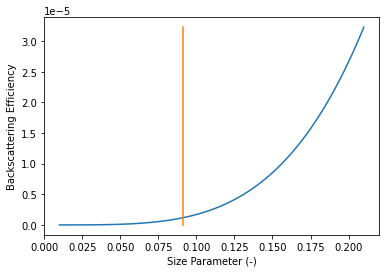

In [12]:
num=100
m=1.1
x=np.linspace(0.01,0.21,num)
qext, qsca, qback, g = miepython.mie(m,x)
    
plt.plot(x,qback)
plt.plot((abs(0.1/m),abs(0.1/m)),(0,qback[num-1]))
plt.xlabel("Size Parameter (-)")
plt.ylabel("Backscattering Efficiency")
plt.show()